## Import Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
images_path = "/content/drive/MyDrive/DataGigi"
train_path = "/train"
val_path = "/validation"
test_path = "/test"

In [1]:
pip install tensorflow

## Import Liblary

In [3]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

## Data Augmentasi

In [10]:
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# pengaturan data validasi selama pelatihan
val_datagen = ImageDataGenerator(rescale=1./255)

# pengaturan data uji untuk evaluasi model
test_datagen = ImageDataGenerator(rescale=1./255)

# menentukan ukuran gambar untuk proses pelatihan
img_size = (224, 224)

# menyiapkan data training dengan pengaturan yang sudah ditentukan
train_data = train_datagen.flow_from_directory(images_path + train_path,
                                               target_size=img_size,
                                               batch_size=32,
                                               class_mode='categorical',
                                               seed=42)

 # menyiapkan data validasi
val_data = val_datagen.flow_from_directory(images_path + val_path,
                                           target_size=img_size,
                                           batch_size=32,
                                           class_mode='categorical',
                                           seed=42)

#menyiapkan data uji
test_data = test_datagen.flow_from_directory(images_path + test_path,
                                             target_size=img_size,
                                             batch_size=32,
                                             class_mode='categorical',
                                             shuffle=False)

Found 1488 images belonging to 5 classes.
Found 372 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


# InceptionV3 Test 1


## Buat Model

In [11]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)


# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add the final output layer with softmax activation
output = Dense(5, activation='softmax')(x)

# Create the model
model_TL = Model(inputs=base_model.input, outputs=output)


# Compile the model
model_TL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Print model summary
model_TL.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [12]:
# Adding callbacks for learning rate reduction and early stopping
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
]

In [13]:
# Training the model
history = model_TL.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    epochs=50,  # Increase the number of epochs
    callbacks=callbacks
)

Epoch 1/50
46/46 [==============================] - 743s 15s/step - loss: 0.7156 - accuracy: 0.7246 - val_loss: 0.7863 - val_accuracy: 0.7642
Epoch 2/50
46/46 [==============================] - 30s 649ms/step - loss: 0.2822 - accuracy: 0.9032 - val_loss: 0.4549 - val_accuracy: 0.8693
Epoch 3/50
46/46 [==============================] - 30s 658ms/step - loss: 0.1752 - accuracy: 0.9423 - val_loss: 0.2535 - val_accuracy: 0.9318
Epoch 4/50
46/46 [==============================] - 29s 631ms/step - loss: 0.1166 - accuracy: 0.9622 - val_loss: 0.2409 - val_accuracy: 0.9375
Epoch 5/50
46/46 [==============================] - 30s 632ms/step - loss: 0.1143 - accuracy: 0.9636 - val_loss: 0.3426 - val_accuracy: 0.9176
Epoch 6/50
46/46 [==============================] - 30s 639ms/step - loss: 0.1016 - accuracy: 0.9684 - val_loss: 0.3151 - val_accuracy: 0.9318
Epoch 7/50
46/46 [==============================] - 30s 634ms/step - loss: 0.0912 - accuracy: 0.9677 - val_loss: 0.2914 - val_accuracy: 0.9432


## Hasil

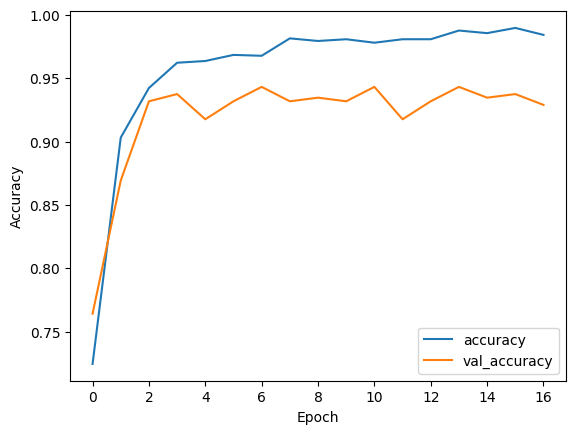

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# InceptionV3 Test 2
## Import Liblary

- Menambahkan lapisan Dropout
- Menambahkan regularisasi L2
- Menambahkan ModelCheckpoint

In [15]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2


## Buat Model

In [16]:
base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add dropout and regularization to the dense layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)

# Add the final output layer with softmax activation
output = Dense(5, activation='softmax')(x)

# Create the model
model_TL2 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_TL2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model_TL2.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalization_94

In [17]:
# Adding callbacks for learning rate reduction and early stopping
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
]

In [18]:
# Training the model
history = model_TL2.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
46/46 [==============================] - 70s 717ms/step - loss: 14.0386 - accuracy: 0.6655 - val_loss: 13.2597 - val_accuracy: 0.7727
Epoch 2/50
46/46 [==============================] - 31s 669ms/step - loss: 12.3371 - accuracy: 0.8750 - val_loss: 11.6902 - val_accuracy: 0.8949
Epoch 3/50
46/46 [==============================] - 31s 668ms/step - loss: 11.0157 - accuracy: 0.9176 - val_loss: 10.5866 - val_accuracy: 0.8835
Epoch 4/50
46/46 [==============================] - 31s 665ms/step - loss: 9.8203 - accuracy: 0.9354 - val_loss: 9.3663 - val_accuracy: 0.9062
Epoch 5/50
46/46 [==============================] - 31s 678ms/step - loss: 8.6544 - accuracy: 0.9560 - val_loss: 8.2180 - val_accuracy: 0.9318
Epoch 6/50
46/46 [==============================] - 30s 648ms/step - loss: 7.5919 - accuracy: 0.9732 - val_loss: 7.2934 - val_accuracy: 0.9233
Epoch 7/50
46/46 [==============================] - 31s 671ms/step - loss: 6.6697 - accuracy: 0.9712 - val_loss: 6.3863 - val_accuracy: 

## Hasil

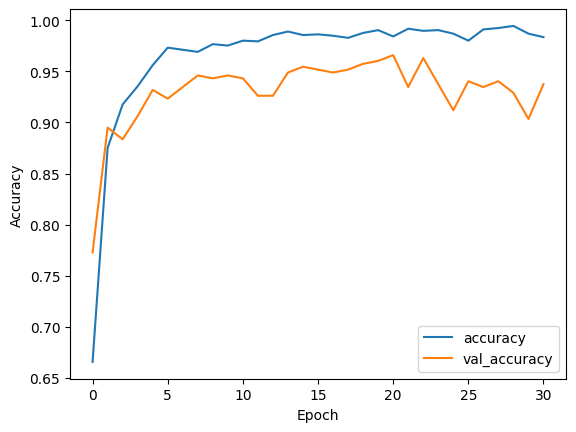

In [19]:
# Plotting the results
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# InceptionV3 Test 3
## Import Liblary

In [20]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

## Buat Model

In [21]:
base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add Batch Normalization and Dropout
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Add additional Dense layers with Batch Normalization and Dropout
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Add the final output layer with softmax activation
output = Dense(5, activation='softmax')(x)

# Create the model
model_TL3 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_TL3.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model_TL3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 111, 111, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_18

In [22]:
# Adding callbacks for learning rate reduction and early stopping
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
]

In [23]:
# Training the model
history = model_TL3.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
46/46 [==============================] - 62s 662ms/step - loss: 13.6209 - accuracy: 0.3628 - val_loss: 12.5006 - val_accuracy: 0.5938
Epoch 2/50
46/46 [==============================] - 30s 658ms/step - loss: 12.6903 - accuracy: 0.5804 - val_loss: 11.9961 - val_accuracy: 0.7841
Epoch 3/50
46/46 [==============================] - 30s 639ms/step - loss: 12.1786 - accuracy: 0.6820 - val_loss: 11.7459 - val_accuracy: 0.7983
Epoch 4/50
46/46 [==============================] - 30s 640ms/step - loss: 11.9102 - accuracy: 0.7232 - val_loss: 11.5657 - val_accuracy: 0.8295
Epoch 5/50
46/46 [==============================] - 30s 652ms/step - loss: 11.6220 - accuracy: 0.7898 - val_loss: 11.2851 - val_accuracy: 0.8835
Epoch 6/50
46/46 [==============================] - 30s 653ms/step - loss: 11.4472 - accuracy: 0.8015 - val_loss: 11.1430 - val_accuracy: 0.8920
Epoch 7/50
46/46 [==============================] - 29s 636ms/step - loss: 11.1446 - accuracy: 0.8468 - val_loss: 10.9658 - val_ac

## Hasil

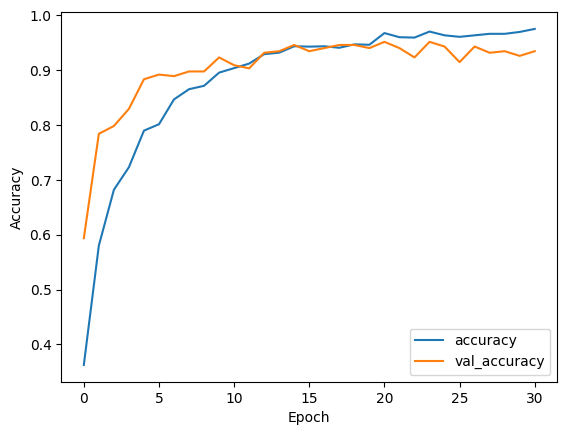

In [24]:
# Plotting the results
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
